<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/DP_MCdrop_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!git clone https://github.com/knamdar/data.git

fatal: destination path 'Bayesian-Neural-Networks' already exists and is not an empty directory.
fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
!pip install opacus==0.13

In [ ]:
import sys;sys.path.append("/content/Bayesian-Neural-Networks")

# Import base pacage

In [ ]:
import opacus
import numpy as np
import torch

import torch.optim as optim
import opacus
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from torchvision import datasets, transforms
from tqdm import tqdm

# Define MC dropout

In [ ]:
from src.priors import *
from src.base_net import *

import torch.nn.functional as F
import torch.nn as nn


def MC_dropout(act_vec, p=0, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(Linear_2L, self).__init__()  # what 

        self.pdrop = 0.5  # what 

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)

        # choose your non linearity
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        # self.act = nn.ELU(inplace=True)
        # self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=True):
        mask = self.training or sample  # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations

        x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y

    def sample_predict(self, x, Nsamples):
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

        for i in range(Nsamples):
            y = self.forward(x, sample=True)
            predictions[i] = y

        return predictions


class MC_drop_net2(BaseNet):
    eps = 1e-6
    # what
    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
        super(MC_drop_net2, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.sr = sr
        self.disable_dp = disable_dp      
        self.sigma = sigma
        self.max_grad_norm = max_grad_norm
        self.secure_rng = secure_rng
        self.classes = classes
        self.n_hid = n_hid
        self.batch_size = batch_size
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.test = False

    # main net and use GPU 
    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        # what 
        self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
                               n_hid=self.n_hid)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    # optimizer 
    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
                                         weight_decay=self.weight_decay)

        if not disable_dp:
            privacy_engine = PrivacyEngine(
                self.model,
                sample_rate=self.sr,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=self.sigma,
                max_grad_norm=self.max_grad_norm,
                secure_rng=self.secure_rng,
            )
            privacy_engine.attach(self.optimizer) # make optimizer private 
    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
    # train 
    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')

        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()
        return loss.data, err
    # test 
    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self):
        weight_vec = []

        state_dict = self.model.state_dict()

        for key in state_dict.keys():

            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)

        return np.array(weight_vec)

# Global Parameters

In [ ]:
#from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
from src.MC_dropout.model import *

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
## global 
weight_decay  = 0

models_dir    = 'MCdrop_models'
results_dir   = 'MCdrop_results'

batch_size = 256
sr      = batch_size/60000
test_batch_size  = 1024 
sigma            = 1.3
delta            = 1e-5
max_per_sample_grad_norm = 200
epochs           = 15
n_runs           = 1
lr               = 0.0002
device           = "cuda"
save_model       = False
secure_rng       = False
data_root        = "/content/data/"
disable_dp       = True




# Where to save models weights
models_dir = models_dir
# Where to save plots and error, accuracy vectors
results_dir = results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
nb_epochs = epochs
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()


trainset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Network:


# MC dropout training MNIST and plot

In [ ]:

########################################################################################

net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
   
    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i+1, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    if not disable_dp:
        epsilon, best_alpha = net.optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)




Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 1/15, Jtr_pred = 0.537704, err = 0.157533,    time: 7.639049 seconds

    Jdev = 0.269703, err = 0.082300

best test error
Writting MCdrop_models/theta_best.dat

it 2/15, Jtr_pred = 0.239564, err = 0.071367,    time: 7.747497 seconds

    Jdev = 0.191328, err = 0.057800

best test error
Writting MCdrop_models/theta_best.dat

it 3/15, Jtr_pred = 0.177665, err = 0.052500,    time: 7.542337 seconds

    Jdev = 0.159575, err = 0.050100

best test error
Writting MCdrop_models/theta_best.dat

it 4/15, Jtr_pred = 0.146215, err = 0.044233,    time: 7.621296 seconds

    Jdev = 0.137449, err = 0.044700

best test error
Writting MCdrop_models/theta_best.dat

it 5/15, Jtr_pred = 0.122192, err = 0.037850,    time: 7.487250 seconds

    Jdev = 0.123069, err = 0.037600

best test error
Writting MCdrop_models/theta_best.dat

it 6/15, Jtr_pred = 0.107547, err = 0.032450,    time: 7.506015 seconds

    Jdev = 0.109180, err

In [ ]:
model_local = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)
model_local.load('/content/theta_best.dat')




Net:
 Creating Net!! 
    Total params: 2.40M
Reading /content/theta_best.dat

  restoring epoch: 14, lr: 0.000200


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


14

In [ ]:
#model_local.to(device)
#model_local.eval()
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = net.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)


100%|██████████| 40/40 [00:01<00:00, 25.59it/s]


In [ ]:
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

-0.002523571318387985

######## ECE: ##############


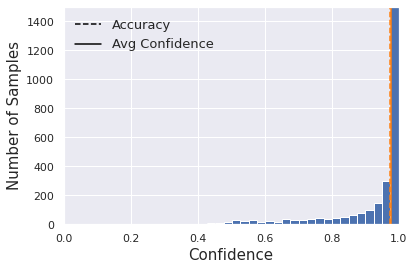

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPMCD.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


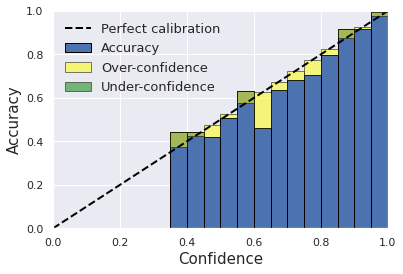

0.16346153846153855

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()

max(abs((xaxis[store_local!=0]-store_local[store_local!=0])))


In [ ]:
net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)
net.load('/content/theta_best.dat')


Net:
 Creating Net!! 
    Total params: 2.40M
Reading /content/theta_best.dat



/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


ModuleNotFoundError: ignored

# Prediction Uncertainty 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


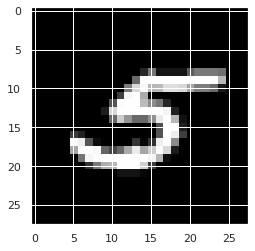

7531 tensor([5]) tensor([1]) tensor([[0.0137, 0.1875, 0.0583, 0.0682, 0.1357, 0.1573, 0.0673, 0.1235, 0.0927,
         0.0959]])


In [ ]:
# set batch_size = 1 and find which index of the graph in the testloader is not predicted well by the current method 
# condition I err.cpu().detach().numpy()==1 : prediction is wrong 
# condition II np.max(probs.cpu().detach().numpy())<0.2 : unconfident prediction 
valloader_plot = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
import torchvision

for j, (x, y) in enumerate(valloader_plot):
    cost, err, probs = net.eval(x, y)
    if err.cpu().detach().numpy()==1 and np.max(probs.cpu().detach().numpy())<0.2:
      img=torchvision.utils.make_grid(x*0.3081+0.1307)
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.show()
      print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


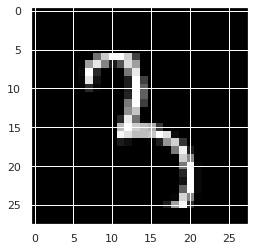

195 tensor([3]) tensor([3]) tensor([[0.0066, 0.1409, 0.0386, 0.2575, 0.1242, 0.1673, 0.0307, 0.0648, 0.0522,
         0.1173]])


<Figure size 432x288 with 0 Axes>

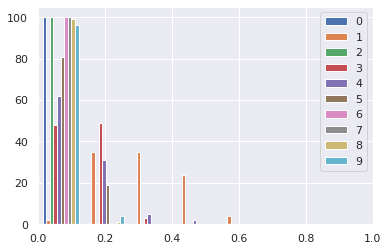

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


404 tensor([2]) tensor([2]) tensor([[0.0700, 0.0657, 0.5335, 0.0755, 0.0006, 0.0607, 0.0103, 0.0079, 0.1746,
         0.0013]])


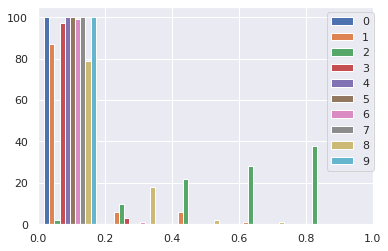

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==195:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)
plt.xlim([0,1])
plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')
plt.savefig('dp_mcb_hist3.pdf',bbox_inches = 'tight')

plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    #plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)
plt.xlim([0,1])
plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right',bbox_to_anchor=(1.02,1))
plt.savefig('dp_mcb_hist2.pdf',bbox_inches = 'tight')
plt.show()




/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


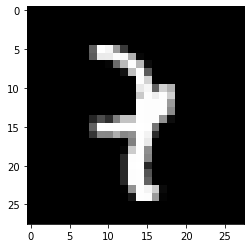

551 tensor([7]) tensor([1]) tensor([[3.8015e-04, 8.6743e-01, 9.0593e-03, 4.7779e-02, 3.5937e-02, 6.1531e-03,
         8.4897e-03, 6.2898e-03, 1.2690e-02, 5.7955e-03]])
True label is tensor([7])


"    \n    for K in range(10): \n        class_col = [sub[K] for sub in hist_prob]\n      # fig = plt.figure()\n        plt.xlim(0, 1) \n        plt.ylim(0, 90) \n        plt.hist(class_col,width=0.02,bins=10)\n        plt.show() \n        f_name = 'dpmc_class'+str(K)\n        print(f_name)\n        plt.savefig(f_name, bbox_inches = 'tight')\n  \nerr_rate\n"

<Figure size 432x288 with 0 Axes>

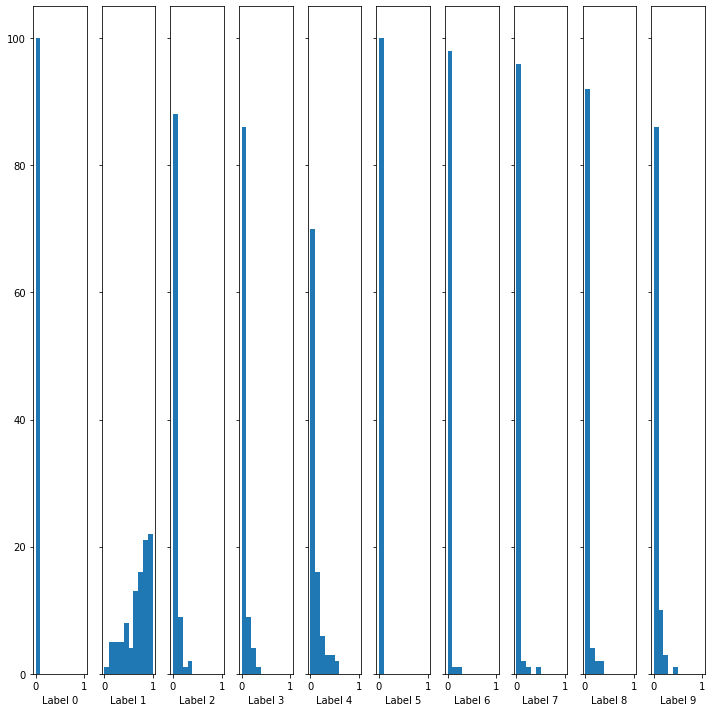

In [ ]:
# Select one of the graph produced by the last chunk, I select 2793
# to compare fairly, we should select the same graph across the methods
# we can select the graph after from the intersection of unconfident graph for all the methods. 
# over 100 repeated samplings : this is the way how mc_dropout does Bayesian inference
# For sgld, you don't have to do it 100 times since you've already save bunches of weights. 


hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==551:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('DP_MC_dropout_hist7.png')

"""    
    for K in range(10): 
        class_col = [sub[K] for sub in hist_prob]
      # fig = plt.figure()
        plt.xlim(0, 1) 
        plt.ylim(0, 90) 
        plt.hist(class_col,width=0.02,bins=10)
        plt.show() 
        f_name = 'dpmc_class'+str(K)
        print(f_name)
        plt.savefig(f_name, bbox_inches = 'tight')
  
err_rate
"""

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


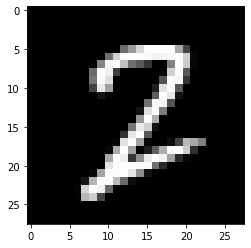

404 tensor([2]) tensor([2]) tensor([[1.9448e-02, 2.1939e-02, 8.8314e-01, 2.6331e-02, 1.6233e-04, 6.5323e-03,
         1.4533e-03, 2.3923e-03, 3.7980e-02, 6.2539e-04]])
True label is tensor([2])


<Figure size 432x288 with 0 Axes>

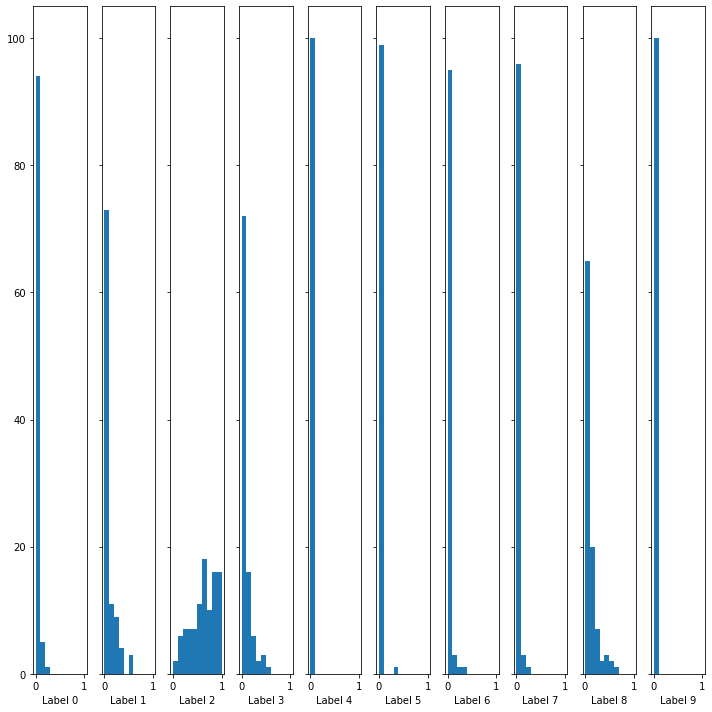

In [ ]:
hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('DP_MC_dropout_hist2.png')

In [ ]:
probs.shape

torch.Size([1, 10])

# Visualization of the result 

<Figure size 600x400 with 0 Axes>

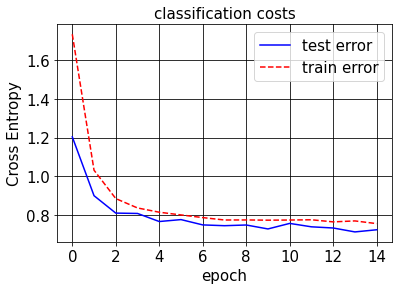

<Figure size 600x400 with 0 Axes>

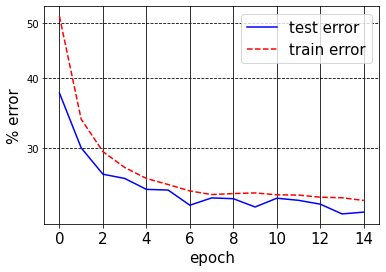

In [ ]:
## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


## NDP-MC Dropout

In [ ]:
from src.priors import *
from src.base_net import *

import torch.nn.functional as F
import torch.nn as nn


def MC_dropout(act_vec, p=0, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(Linear_2L, self).__init__()  # what 

        self.pdrop = 0.5  # what 

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)

        # choose your non linearity
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        # self.act = nn.ELU(inplace=True)
        # self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=True):
        mask = self.training or sample  # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations

        x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y

    def sample_predict(self, x, Nsamples):
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

        for i in range(Nsamples):
            y = self.forward(x, sample=True)
            predictions[i] = y

        return predictions


class MC_drop_net2(BaseNet):
    eps = 1e-6
    # what
    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
        super(MC_drop_net2, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.sr = sr
        self.disable_dp = disable_dp      
        self.sigma = sigma
        self.max_grad_norm = max_grad_norm
        self.secure_rng = secure_rng
        self.classes = classes
        self.n_hid = n_hid
        self.batch_size = batch_size
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.test = False

    # main net and use GPU 
    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        # what 
        self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
                               n_hid=self.n_hid)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    # optimizer 
    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
                                         weight_decay=self.weight_decay)

        if not disable_dp:
            privacy_engine = PrivacyEngine(
                self.model,
                sample_rate=self.sr,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=self.sigma,
                max_grad_norm=self.max_grad_norm,
                secure_rng=self.secure_rng,
            )
            privacy_engine.attach(self.optimizer) # make optimizer private 
    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
    # train 
    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')

        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()
        return loss.data, err
    # test 
    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self):
        weight_vec = []

        state_dict = self.model.state_dict()

        for key in state_dict.keys():

            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)

        return np.array(weight_vec)

In [ ]:
#from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
from src.MC_dropout.model import *

#matplotlib.use('Agg')
import matplotlib.pyplot as plt

## global 
weight_decay  = 1.0 

models_dir    = 'MCdrop_models'
results_dir   = 'MCdrop_results'

batch_size = 128
sr      = batch_size/60000
test_batch_size  = 1024 
sigma            = 1.3
delta            = 1e-5
max_per_sample_grad_norm = 200
epochs           = 15
n_runs           = 1
lr               = 0.0002
device           = "cuda"
save_model       = False
secure_rng       = False
data_root        = "/content/data/"
disable_dp       = False




# Where to save models weights
models_dir = models_dir
# Where to save plots and error, accuracy vectors
results_dir = results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
nb_epochs = epochs
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()


trainset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Network:


In [ ]:

########################################################################################

net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
   
    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i+1, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    if not disable_dp:
        epsilon, best_alpha = net.optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)




Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when 

it 1/15, Jtr_pred = 1.739811, err = 0.517700,    time: 9.949773 seconds

(ε = 0.62, δ = 1e-05) for α = 20.0
    Jdev = 1.196846, err = 0.369500

best test error
Writting MCdrop_models/theta_best.dat

it 2/15, Jtr_pred = 1.025257, err = 0.337050,    time: 9.794855 seconds

(ε = 0.64, δ = 1e-05) for α = 20.0
    Jdev = 0.872036, err = 0.295000

best test error
Writting MCdrop_models/theta_best.dat

it 3/15, Jtr_pred = 0.860067, err = 0.289017,    time: 9.833725 seconds

(ε = 0.66, δ = 1e-05) for α = 20.0
    Jdev = 0.804040, err = 0.271000

best test error
Writting MCdrop_models/theta_best.dat

it 4/15, Jtr_pred = 0.808358, err = 0.268783,    time: 9.935396 seconds

(ε = 0.68, δ = 1e-05) for α = 20.0
    Jdev = 0.789179, err = 0.259400

best test error
Writting MCdrop_models/theta_best.dat

it 5/15, Jtr_pred = 0.795198, err = 0.260600,    time: 9.971340 seconds

(ε = 0.70, δ = 1e-05) for α = 20.0
    Jdev = 0.760274, err = 0.252900

best test error
Writting MCdrop_models/theta_best.dat



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==195:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    #plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)

plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')

plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)

#plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')

plt.show()



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


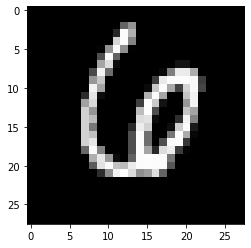

66 tensor([6]) tensor([2]) tensor([[0.1437, 0.0936, 0.1992, 0.1113, 0.0282, 0.0249, 0.1715, 0.0846, 0.1176,
         0.0255]])


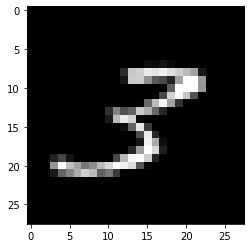

9655 tensor([3]) tensor([1]) tensor([[0.0124, 0.1940, 0.0120, 0.1073, 0.0305, 0.0609, 0.1248, 0.1220, 0.1450,
         0.1912]])


In [ ]:
# set batch_size = 1 and find which index of the graph in the testloader is not predicted well by the current method 
# condition I err.cpu().detach().numpy()==1 : prediction is wrong 
# condition II np.max(probs.cpu().detach().numpy())<0.2 : unconfident prediction 
valloader_plot = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
import torchvision

for j, (x, y) in enumerate(valloader_plot):
    cost, err, probs = net.eval(x, y)
    if err.cpu().detach().numpy()==1 and np.max(probs.cpu().detach().numpy())<0.2:
      img=torchvision.utils.make_grid(x*0.3081+0.1307)
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.show()
      print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


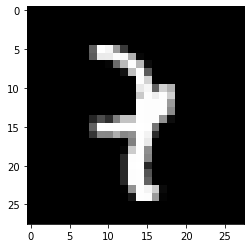

551 tensor([7]) tensor([1]) tensor([[1.5610e-05, 8.9539e-01, 3.4375e-03, 1.7053e-02, 1.8422e-03, 1.2590e-03,
         2.1239e-03, 2.9885e-02, 5.8258e-03, 4.3166e-02]])
True label is tensor([7])


"    \n    for K in range(10): \n        class_col = [sub[K] for sub in hist_prob]\n      # fig = plt.figure()\n        plt.xlim(0, 1) \n        plt.ylim(0, 90) \n        plt.hist(class_col,width=0.02,bins=10)\n        plt.show() \n        f_name = 'dpmc_class'+str(K)\n        print(f_name)\n        plt.savefig(f_name, bbox_inches = 'tight')\n  \nerr_rate\n"

<Figure size 432x288 with 0 Axes>

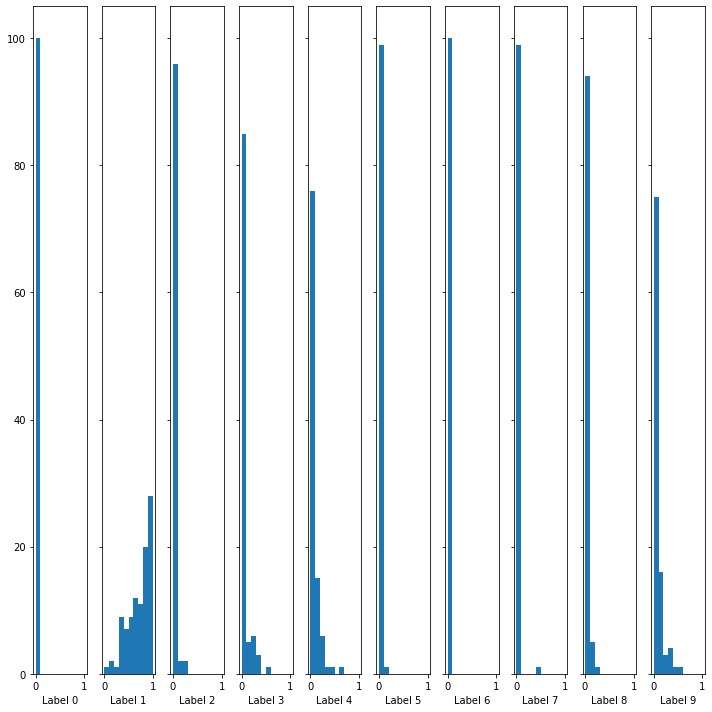

In [ ]:
# Select one of the graph produced by the last chunk, I select 2793
# to compare fairly, we should select the same graph across the methods
# we can select the graph after from the intersection of unconfident graph for all the methods. 
# over 100 repeated samplings : this is the way how mc_dropout does Bayesian inference
# For sgld, you don't have to do it 100 times since you've already save bunches of weights. 
hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==551:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('non_DP_MC_dropout_hist7.png')

"""    
    for K in range(10): 
        class_col = [sub[K] for sub in hist_prob]
      # fig = plt.figure()
        plt.xlim(0, 1) 
        plt.ylim(0, 90) 
        plt.hist(class_col,width=0.02,bins=10)
        plt.show() 
        f_name = 'dpmc_class'+str(K)
        print(f_name)
        plt.savefig(f_name, bbox_inches = 'tight')
  
err_rate
"""

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


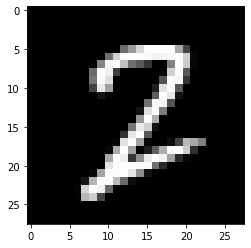

404 tensor([2]) tensor([2]) tensor([[0.0052, 0.1795, 0.5741, 0.0101, 0.0010, 0.0160, 0.1789, 0.0058, 0.0257,
         0.0038]])
True label is tensor([2])


"    \n    for K in range(10): \n        class_col = [sub[K] for sub in hist_prob]\n      # fig = plt.figure()\n        plt.xlim(0, 1) \n        plt.ylim(0, 90) \n        plt.hist(class_col,width=0.02,bins=10)\n        plt.show() \n        f_name = 'dpmc_class'+str(K)\n        print(f_name)\n        plt.savefig(f_name, bbox_inches = 'tight')\n  \nerr_rate\n"

<Figure size 432x288 with 0 Axes>

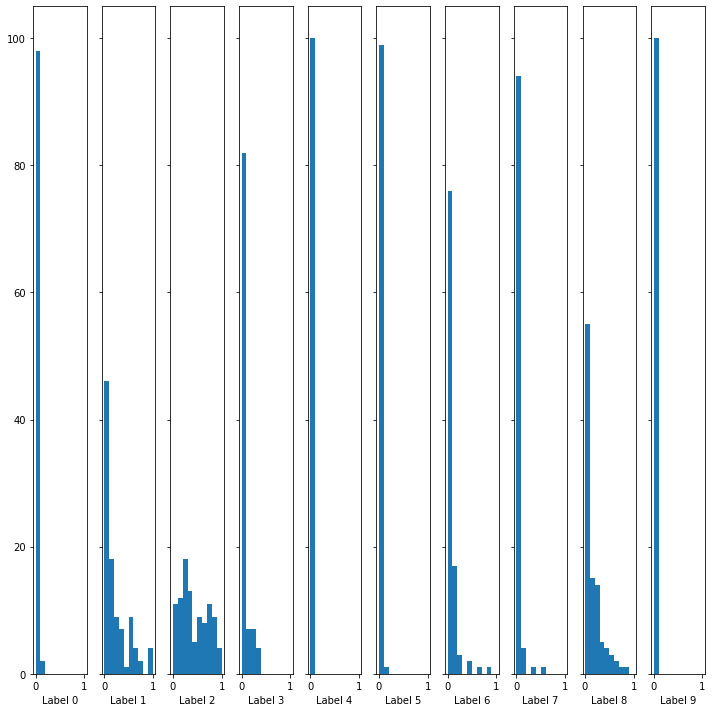

In [ ]:
# Select one of the graph produced by the last chunk, I select 2793
# to compare fairly, we should select the same graph across the methods
# we can select the graph after from the intersection of unconfident graph for all the methods. 
# over 100 repeated samplings : this is the way how mc_dropout does Bayesian inference
# For sgld, you don't have to do it 100 times since you've already save bunches of weights. 
hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('non_DP_MC_dropout_hist7.png')

"""    
    for K in range(10): 
        class_col = [sub[K] for sub in hist_prob]
      # fig = plt.figure()
        plt.xlim(0, 1) 
        plt.ylim(0, 90) 
        plt.hist(class_col,width=0.02,bins=10)
        plt.show() 
        f_name = 'dpmc_class'+str(K)
        print(f_name)
        plt.savefig(f_name, bbox_inches = 'tight')
  
err_rate
"""

#Linear 2 layers with droprate = 0 

In [ ]:
from src.priors import *
from src.base_net import *

import torch.nn.functional as F
import torch.nn as nn


def MC_dropout(act_vec, p=0, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(Linear_2L, self).__init__()  # what 

        self.pdrop = 0  # what 

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)

        # choose your non linearity
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        # self.act = nn.ELU(inplace=True)
        # self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=True):
        mask = self.training or sample  # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations

        x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y

    def sample_predict(self, x, Nsamples):
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

        for i in range(Nsamples):
            y = self.forward(x, sample=True)
            predictions[i] = y

        return predictions


class MC_drop_net2(BaseNet):
    eps = 1e-6
    # what
    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
        super(MC_drop_net2, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.sr = sr
        self.disable_dp = disable_dp      
        self.sigma = sigma
        self.max_grad_norm = max_grad_norm
        self.secure_rng = secure_rng
        self.classes = classes
        self.n_hid = n_hid
        self.batch_size = batch_size
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.test = False

    # main net and use GPU 
    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        # what 
        self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
                               n_hid=self.n_hid)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    # optimizer 
    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
                                         weight_decay=self.weight_decay)

        if not disable_dp:
            privacy_engine = PrivacyEngine(
                self.model,
                sample_rate=self.sr,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=self.sigma,
                max_grad_norm=self.max_grad_norm,
                secure_rng=self.secure_rng,
            )
            privacy_engine.attach(self.optimizer) # make optimizer private 
    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
    # train 
    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')

        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()
        return loss.data, err
    # test 
    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self):
        weight_vec = []

        state_dict = self.model.state_dict()

        for key in state_dict.keys():

            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)

        return np.array(weight_vec)

ModuleNotFoundError: ignored

In [ ]:
#from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
from src.MC_dropout.model import *

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
## global 
weight_decay  = 1.0 

models_dir    = 'MCdrop_models'
results_dir   = 'MCdrop_results'

batch_size = 128
sr      = batch_size/60000
test_batch_size  = 1024 
sigma            = 1.3
delta            = 1e-5
max_per_sample_grad_norm = 200
epochs           = 15
n_runs           = 1
lr               = 0.0002
device           = "cuda"
save_model       = False
secure_rng       = False
data_root        = "/content/data/"
disable_dp       = False




# Where to save models weights
models_dir = models_dir
# Where to save plots and error, accuracy vectors
results_dir = results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
nb_epochs = epochs
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()


trainset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Network:


In [ ]:

########################################################################################

net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
   
    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i+1, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    if not disable_dp:
        epsilon, best_alpha = net.optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)




Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when 

it 1/15, Jtr_pred = 1.724395, err = 0.504067,    time: 10.098547 seconds

(ε = 0.62, δ = 1e-05) for α = 20.0
    Jdev = 1.188233, err = 0.361100

best test error
Writting MCdrop_models/theta_best.dat

it 2/15, Jtr_pred = 1.013681, err = 0.332283,    time: 9.818381 seconds

(ε = 0.64, δ = 1e-05) for α = 20.0
    Jdev = 0.869439, err = 0.290400

best test error
Writting MCdrop_models/theta_best.dat

it 3/15, Jtr_pred = 0.862971, err = 0.291283,    time: 9.664048 seconds

(ε = 0.66, δ = 1e-05) for α = 20.0
    Jdev = 0.797215, err = 0.274100

best test error
Writting MCdrop_models/theta_best.dat

it 4/15, Jtr_pred = 0.819528, err = 0.272250,    time: 9.549320 seconds

(ε = 0.68, δ = 1e-05) for α = 20.0
    Jdev = 0.797852, err = 0.265900

best test error
Writting MCdrop_models/theta_best.dat

it 5/15, Jtr_pred = 0.808390, err = 0.265617,    time: 9.541250 seconds

(ε = 0.70, δ = 1e-05) for α = 20.0
    Jdev = 0.766668, err = 0.250000

best test error
Writting MCdrop_models/theta_best.dat


# Convolutional Layers 

In [ ]:
from src.priors import *
from src.base_net import *

import torch.nn.functional as F
import torch.nn as nn


def MC_dropout(act_vec, p=0, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "SampleConvNet"


    def sample_predict(self, x, Nsamples):
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

        for i in range(Nsamples):
            y = self.forward(x, sample=True)
            predictions[i] = y

        return predictions


class MC_drop_net2(BaseNet):
    eps = 1e-6
    # what
    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
        super(MC_drop_net2, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.sr = sr
        self.disable_dp = disable_dp      
        self.sigma = sigma
        self.max_grad_norm = max_grad_norm
        self.secure_rng = secure_rng
        self.classes = classes
        self.n_hid = n_hid
        self.batch_size = batch_size
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.test = False

    # main net and use GPU 
    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        # what 
        self.model = SampleConvNet(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
                               n_hid=self.n_hid)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    # optimizer 
    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
                                         weight_decay=self.weight_decay)

        if not disable_dp:
            privacy_engine = PrivacyEngine(
                self.model,
                sample_rate=self.sr,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=self.sigma,
                max_grad_norm=self.max_grad_norm,
                secure_rng=self.secure_rng,
            )
            privacy_engine.attach(self.optimizer) # make optimizer private 
    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
    # train 
    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')

        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()
        return loss.data, err
    # test 
    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self):
        weight_vec = []

        state_dict = self.model.state_dict()

        for key in state_dict.keys():

            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)

        return np.array(weight_vec)

In [ ]:
#from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
from src.MC_dropout.model import *

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
## global 
weight_decay  = 1.0 

models_dir    = 'MCdrop_models'
results_dir   = 'MCdrop_results'

batch_size = 128
sr      = batch_size/60000
test_batch_size  = 1024 
sigma            = 1.3
delta            = 1e-5
max_per_sample_grad_norm = 200
epochs           = 15
n_runs           = 1
lr               = 0.0002
device           = "cuda"
save_model       = False
secure_rng       = False
data_root        = "/content/data/"
disable_dp       = True




# Where to save models weights
models_dir = models_dir
# Where to save plots and error, accuracy vectors
results_dir = results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
nb_epochs = epochs
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()


trainset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Network:


In [ ]:

########################################################################################

net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
   
    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i+1, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    if not disable_dp:
        epsilon, best_alpha = net.optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)




Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 1/15, Jtr_pred = 0.541882, err = 0.157433,    time: 8.569550 seconds

    Jdev = 0.291515, err = 0.088900

best test error
Writting MCdrop_models/theta_best.dat

it 2/15, Jtr_pred = 0.262630, err = 0.076000,    time: 8.386936 seconds

    Jdev = 0.219035, err = 0.065500

best test error
Writting MCdrop_models/theta_best.dat

it 3/15, Jtr_pred = 0.209247, err = 0.061150,    time: 8.349829 seconds

    Jdev = 0.188712, err = 0.056500

best test error
Writting MCdrop_models/theta_best.dat

it 4/15, Jtr_pred = 0.182585, err = 0.051717,    time: 8.352703 seconds

    Jdev = 0.167221, err = 0.046900

best test error
Writting MCdrop_models/theta_best.dat

it 5/15, Jtr_pred = 0.163682, err = 0.045133,    time: 8.382046 seconds

    Jdev = 0.157775, err = 0.043200

best test error
Writting MCdrop_models/theta_best.dat

it 6/15, Jtr_pred = 0.154532, err = 0.042750,    time: 8.270500 seconds

    Jdev = 0.152447, err

In [ ]:
#model_local.to(device)
#model_local.eval()
from tqdm import tqdm
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = net.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))


100%|██████████| 79/79 [00:01<00:00, 50.85it/s]


0.030585847824811996

######## ECE: ##############


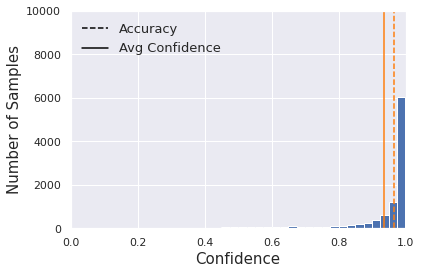

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
plt.ylim(0,10000)
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,10000,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,10000,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)

plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPBBP.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


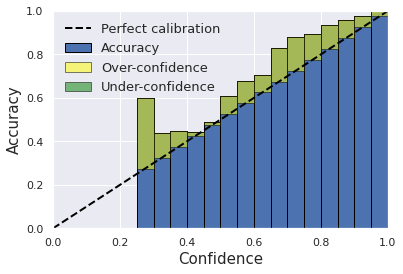

0.32499999999999996

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()
max(abs((xaxis[store_local!=0]-store_local[store_local!=0])))


In [ ]:
import numpy as np
bbpgerr_dev = np.load('/content/bbpgerr_dev.npy')
mcderr_dev = np.load('/content/mcderr_dev.npy')
bbpgerr_dev = np.repeat(1,15) - bbpgerr_dev
mcderr_dev  = np.repeat(1,15) - mcderr_dev
sgldgerr_dev = np.repeat(1,15) - [0.113,0.109100,0.14,0.1126,0.13,0.1147,0.1088, 0.1051,0.1049, 0.1074,0.1178,0.1133,0.1165,0.1068,0.1136]
#bbplerr_dev = [0.34,0.30,0.27,0.26,0.24,0.25,0.221,0.221,0.223,0.224,0.212,0.230,0.208,0.214,0.202]

err_dev =np.repeat(1,15)-[0.084 , 0.0675, 0.0551, 0.0465, 0.0446, 0.0423, 0.0434, 0.0403, 0.0393, 0.0367, 0.0367, 0.0355, 0.0369, 0.0338, 0.0346]

nb_epochs = 15
nb_its_dev = 1
mcderr_dev


FileNotFoundError: ignored

NameError: ignored

<Figure size 600x400 with 0 Axes>

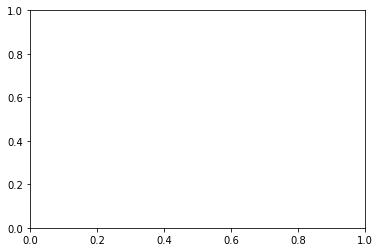

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
plt.plot(range(15),err_dev)
plt.plot(range(15),bbpgerr_dev)
plt.plot(range(15),sgldgerr_dev)
plt.plot(range(15),mcderr_dev)
plt.ylim([0.5,1])
plt.xlabel('epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(['DP-SGD','DP-BBP','DP-SGLD','DP-MC Dropout'])
plt.savefig('error.pdf',bbox_inches = 'tight',fontsize=14)